In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

check_gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if check_gpu \
      else "NOT AVAILABLE" )

#tipos de datos 
DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)   #establece el tipo de float predeterminado

GPU is available


## Dominios

In [2]:
xmax = 2.0
xmin = 0.0
ymax = 2.0
ymin = 0.0

In [4]:
N_r = 1200

x_r = tf.constant(xmin + (xmax - xmin) * np.random.rand(N_r), shape = (N_r, 1), dtype = DTYPE)
y_r = tf.constant(ymin + (ymax - ymin) * np.random.rand(N_r), shape = (N_r, 1), dtype = DTYPE)
X_r = tf.concat([x_r, y_r], axis = 1)

In [7]:
N_u = 100 

#borde (x,0)
x_1 = tf.constant(xmin + (xmax - xmin) * np.random.rand(N_u, 1), dtype = DTYPE)
y_1 = tf.ones((N_u, 1), dtype = DTYPE) * ymin
X_1 = tf.concat([x_1, y_1], axis = 1)

#borde (x,2)
x_2 = tf.constant(xmin + (xmax - xmin) * np.random.rand(N_u, 1), dtype = DTYPE)
y_2 = tf.ones((N_u, 1), dtype = DTYPE) * ymax
X_2 = tf.concat([x_2, y_2], axis = 1)

#borde(0,y)
x_3 = tf.ones((N_u, 1), dtype = DTYPE) * xmin
y_3 = tf.constant(ymin + (ymax - ymin) * np.random.rand(N_u, 1), dtype = DTYPE)
X_3 = tf.concat([x_3, y_3], axis = 1)

#borde(2,y)
x_4 = tf.ones((N_u, 1), dtype = DTYPE) * xmax
y_4 = tf.constant(ymin + (ymax - ymin) * np.random.rand(N_u, 1), dtype = DTYPE)
X_4 = tf.concat([x_4, y_4], axis = 1)

Text(0, 0.5, 'x')

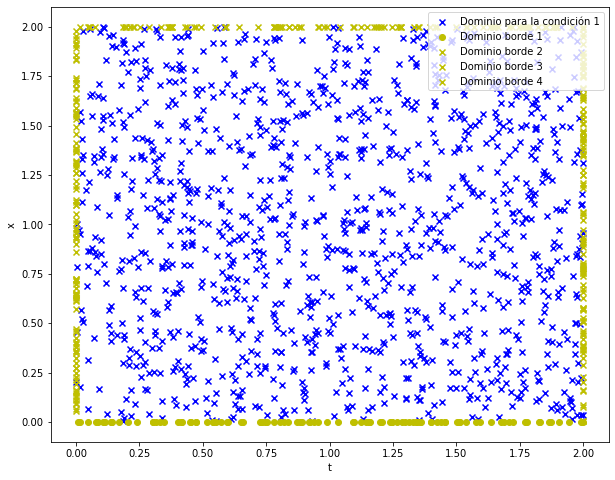

In [10]:
plt.figure(figsize=(10,8))
plt.scatter(x_r, y_r, marker = 'x', color = 'b', label = 'Dominio para la condición 1')
plt.scatter(x_1, y_1, marker = 'o', color = 'y', label = 'Dominio borde 1')
plt.scatter(x_2,y_2, marker = 'x', color = 'y', label = 'Dominio borde 2' )
plt.scatter(x_3, y_3, marker = 'x', color = 'y', label = 'Dominio borde 3' )
plt.scatter(x_4, y_4, marker = 'x', color = 'y', label = 'Dominio borde 4' )
plt.legend(loc='upper right')
plt.xlabel('t')
plt.ylabel('x')

## Funciones para definir la condicion inicial,condición de borde y EDP

In [52]:
def f(X):
    x = X[:,0:1]
    y = X[:,1:2]
    return 12 * ( x**2 + y**2 ) - 24 * ( x + y )

def g(X):
    x = X[:,0:1]
    y = X[:,1:2]
    return tf.zeros_like(x)


In [53]:
def f_res(u_xx, y_xx):
    return u_xx + y_xx

## Red Neuronal

In [54]:
#Red Neuronal
def init_model(num_hidden_layers = 3, num_neurons_per_layer = 20 ):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(2))

    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer, 
                                        activation = tf.keras.activations.get('tanh'),
                                       kernel_initializer = 'glorot_normal'))
    
    model.add(tf.keras.layers.Dense(1))
    return model

In [55]:
model_1 = init_model()

In [56]:
#Derivadas de la red neuronal
def get_diff(model, X):
    x = X[:,0:1]
    y = X[:,1:2]
    with tf.GradientTape(persistent=True) as outer_tape:
        outer_tape.watch(x)
        outer_tape.watch(y)
        with tf.GradientTape(persistent=True) as inner_tape:
            inner_tape.watch(x)
            inner_tape.watch(y)
            u = model(tf.concat([x, y], axis = 1))
        u_x = inner_tape.gradient(u, x)
        u_y = inner_tape.gradient(u, y)
    u_xx = outer_tape.gradient(u_x, x)
    u_yy = outer_tape.gradient(u_y, y)
    return  u_xx, u_yy   

## Función de Pérdida

In [57]:
def compute_loss(model, X_colocacion, X_borde_1, X_borde_2, X_borde_3, X_borde_4):
    u_xx, u_yy = get_diff(model, X_colocacion)
    
    loss_r = tf.reduce_mean(tf.square(f_res(u_xx,u_yy) - f(X_colocacion) ))
    
    loss_bc_1 = tf.reduce_mean(tf.square(model(X_borde_1) - g(X_borde_1)))
    loss_bc_2 = tf.reduce_mean(tf.square(model(X_borde_2) - g(X_borde_2)))
    loss_bc_3 = tf.reduce_mean(tf.square(model(X_borde_3) - g(X_borde_3)))
    loss_bc_4 = tf.reduce_mean(tf.square(model(X_borde_4) - g(X_borde_4)))
  
    loss = loss_r + loss_bc_1 + loss_bc_2 + loss_bc_3 + loss_bc_4
    return loss, loss_r, loss_bc_1, loss_bc_2, loss_bc_3, loss_bc_4

In [58]:
#compute_loss(model_1, X_r, X_1, X_2, X_3, X_4)

In [59]:
#model_1(X_1)

In [60]:
#Derivada de la función de pérdida con respecto a los pesos de la red neuronal
def loss_grad(model, X_colocacion, X_borde_1, X_borde_2, X_borde_3, X_borde_4):
    with tf.GradientTape() as tape:
        loss, _, _, _, _, _ = compute_loss(model, X_colocacion, X_borde_1, X_borde_2, X_borde_3, X_borde_4)
    g = tape.gradient(loss, model.trainable_variables)
    return loss, g

In [61]:
optim = tf.keras.optimizers.Adam(0.001)

In [62]:
#Función que realiza un paso en el preceso de descenso de gradiente aplicado a la función de pérdida
@tf.function 
def train_step(model, X_colocacion, X_borde_1, X_borde_2, X_borde_3, X_borde_4):
    loss, grad_theta = loss_grad(model, X_colocacion, X_borde_1, X_borde_2, X_borde_3, X_borde_4)
    
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))  #un paso descenso de gradiente
    return loss

In [67]:
#diccionario que guardará el conmputo de las componentes de la loss
hist = {'loss': [2,3,4],
        'r_pinn': [],
        'r_i': [],
        'r_1': [],
        'r_2': [], 
        } 

In [64]:
from time import time  

#Número de Épocas
N = 10000

#Comienzo del tiempo
t0 = time()

#Entrenamiento
for i in range(N+1):
    #Actualización de los pesos de la función de pérdida 
    loss = train_step(model_1, X_r, X_1, X_2, X_3, X_4)  

    hist_1.append(loss.numpy())
    
    #Visualiza el avance de la función de pérdida
    if i%1000 == 0:
        print(f'It {i:05d}: loss = {loss:10.8e}')
        
#Mostrar tiempo de calculo 
print(f'Tiempo de Cómputo: {time()-t0} segundos')


2024-04-17 12:30:50.184878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


It 00000: loss = 2.77917267e+02
It 01000: loss = 1.52971077e+00
It 02000: loss = 5.10599494e-01
It 03000: loss = 2.17834935e-01
It 04000: loss = 8.86494368e-02
It 05000: loss = 3.46435420e-02
It 06000: loss = 2.05018632e-02
It 07000: loss = 1.29886288e-02
It 08000: loss = 8.71885568e-03
It 09000: loss = 5.98653266e-03
It 10000: loss = 4.54564765e-03
Tiempo de Cómputo: 106.07841897010803 segundos


In [65]:
from ipywidgets import interactive
import ipywidgets as widgets

#grafica solución 
N = 500

xspace = np.linspace(xmin, xmax, N + 1)
yspace = np.linspace(ymin, ymax, N + 1)
X, Y = np.meshgrid(xspace, yspace)
Xgrid = np.vstack([X.flatten(),Y.flatten()]).T

# Determine predictions of u(t, x)
upred = model_1(tf.cast(Xgrid,DTYPE))

# Reshape upred
U = upred.numpy().reshape(N+1,N+1)

def plot_surface(elev=30, azim=30):
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, U, cmap='viridis')
    ax.view_init(elev, azim)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$u_\\theta(t,x)$')
    ax.set_title('Solution Pinn Burger')
    plt.show()

elev_slider = widgets.IntSlider(min=0, max=90, step=1, value=30, description='Elevación')
azim_slider = widgets.IntSlider(min=0, max=360, step=1, value=30, description='Azimut')

interactive_plot = interactive(plot_surface, elev=elev_slider, azim=azim_slider)
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot


interactive(children=(IntSlider(value=30, description='Elevación', max=90), IntSlider(value=30, description='A…